In [1]:
import os
from pathlib import Path

import numpy as np
import onnx
import onnxruntime as ort
import pandas as pd
import pygrib
import run_pangu
import xarray
from run_pangu import s1_get_gefs, s2_make_ic_gefs
from run_pangu.s3_run_fengwu_ecmwf import (
    fengwu_channels,
    pressure_levels,
    setup_model_sessions,
    variables,
)

In [33]:
date = pd.to_datetime("2023050100", format="%Y%m%d%H")
date_6 = date - pd.to_timedelta("6h")

s1_get_gefs.download_time(date_6)
s1_get_gefs.download_time(date)

s2_make_ic_gefs.process_member(date_6.strftime("%Y%m%d%H"), "c00")
s2_make_ic_gefs.process_member(date.strftime("%Y%m%d%H"), "c00")

/glade/derecho/scratch/ahijevyc/ai-models/input/2023043018/c00/gec00.t18z.pgrb.0p25.f000 exists already. skipping
/glade/derecho/scratch/ahijevyc/ai-models/input/2023050100/c00/gec00.t00z.pgrb.0p25.f000 exists already. skipping


In [18]:
model_dir = Path("/glade/derecho/scratch/zxhua/AI_global_forecast_model_for_education/FengWu/model")
# Load normalization data
data_mean = np.load(model_dir / "data_mean.npy")[:, np.newaxis, np.newaxis]
data_std = np.load(model_dir / "data_std.npy")[:, np.newaxis, np.newaxis]
ort_session_6 = setup_model_sessions(model_dir)

2025-04-17 13:51:55.242787327 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-17 13:51:55.242830884 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [34]:
ai_models_dir = Path("/glade/derecho/scratch/ahijevyc/ai-models")
prior_grb = ai_models_dir / f"input/{date_6:%Y%m%d%H}/c00/gec00.t{date_6:%H}z.pgrb.0p25.f000"
current_grb = ai_models_dir / f"input/{date:%Y%m%d%H}/c00/gec00.t{date:%H}z.pgrb.0p25.f000"

In [35]:
import earthkit.data as ekd


def fengwu_input(grb):
    input = ekd.from_source("file", grb)
    pressure_levels_int = [int(p) for p in pressure_levels]
    sfc_param = ["10u", "10v", "2t", "msl"]
    fields_sfc = input.sel(param=sfc_param, levtype="sfc").order_by(param=sfc_param)
    fields_pl = input.sel(param=variables, level=pressure_levels_int, levtype="pl").order_by(
        param=variables, level=pressure_levels_int
    )
    fields_all = fields_sfc + fields_pl
    #print(fields_all.ls())
    return fields_all.to_numpy()

input_prior = fengwu_input(prior_grb)
input_current = fengwu_input(current_grb)

In [36]:
input_current_after_norm = (input_current - data_mean) / data_std
input_prior_after_norm = (input_prior - data_mean) / data_std
for data, f in zip(input_current_after_norm, fengwu_channels):
    m = data.mean
    if np.abs(data.mean()) > 1:
        print(data.mean(), f)

-13.50843386353264 q50
-2.78245122914732 q100


In [42]:
# Normalize input data
input_current_after_norm = (input_current - data_mean) / data_std
input_prior_after_norm = (input_prior - data_mean) / data_std
input_fengwu = np.concatenate((input_prior_after_norm, input_current_after_norm), axis=0)[
    np.newaxis, :, :, :
]
input_fengwu = input_fengwu.astype(np.float32)
print(input_fengwu.shape)

input = input_fengwu
# Define the coordinates
lat = np.linspace(90, -90, 721)
lon = np.linspace(0, 359.75, 1440)
clobber = False
for fhr in range(6, 246, 6):
    odir = current_grb.parent.as_posix().replace("input", "output/fengwu")
    output_filename = f"{odir}/fengwu_pred_{fhr:03d}.nc"
    if os.path.exists(output_filename):
        if clobber:
            os.remove(output_filename)
        else:
            print('.', end='')
            continue
    print(f"Processing {date:%Y-%m-%d} - {fhr} hour")
    output = ort_session_6.run(None, {"input": input})[0]
    input = np.concatenate((input[:, 69:], output[:, :69]), axis=1)
    output = (output[0, :69] * data_std) + data_mean

    # Create prediction timedelta
    pred_timedelta = pd.Timedelta(hours=fhr)

    # Create xarray DataArrays with proper dimensions
    da_output = xarray.DataArray(
        data=np.expand_dims(np.expand_dims(output, axis=0), axis=0),
        coords={
            "init_time": [date],
            "prediction_timedelta": [pred_timedelta],
            "channel": fengwu_channels,
            "lat": lat,
            "lon": lon,
        },
        dims=["init_time", "prediction_timedelta", "channel", "lat", "lon"],
    )  # .sel(lat=slice(60, 20), lon=slice(220, 300))

    # Save as netCDF
    os.makedirs(odir, exist_ok=True)
    output_filename = f"{odir}/fengwu_pred_{fhr:03d}.nc"
    da_output.to_netcdf(output_filename)

(1, 138, 721, 1440)
........................................

In [41]:
odir

'/glade/derecho/scratch/ahijevyc/ai-models/output/fengwu/2023050106/c00'

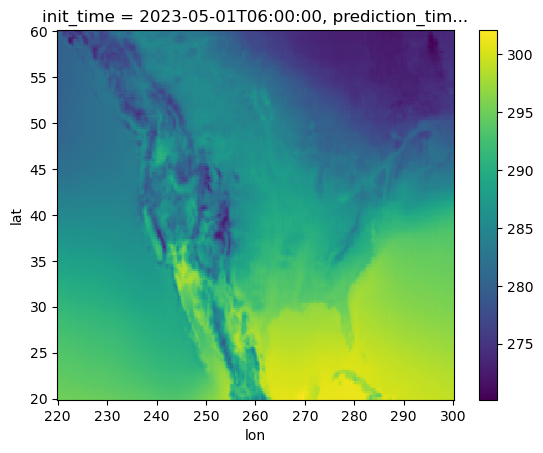

In [39]:
da_output.sel(lat=slice(60,20), lon=slice(220,300)).sel(channel="t2m").plot()

In [40]:
da = (
    xarray.open_mfdataset(Path(odir).glob("*"), decode_timedelta=True)
    .sel(channel="z500", init_time=date)
    .squeeze()["__xarray_dataarray_variable__"]
    .isel(prediction_timedelta=slice(None, None, 4))
)
da.sel(lat=slice(60,20), lon=slice(220,300)).plot(col="prediction_timedelta", col_wrap=3)

KeyError: "not all values found in index 'init_time'. Try setting the `method` keyword argument (example: method='nearest')."

In [31]:
da_old = (
    xarray.open_mfdataset(Path(f"/glade/derecho/scratch/sobash/fengwu_realtime/{date:%Y%m%d%H}/hres/fengwu_forecast_data").glob("*"), decode_timedelta=True)
    .sel(channel="t2m")
    .squeeze()["__xarray_dataarray_variable__"]
    .isel(prediction_timedelta=slice(None, None, 4))
)
da_old.plot(col="prediction_timedelta", col_wrap=3)

OSError: no files to open

In [14]:
da

<xarray.DataArray '__xarray_dataarray_variable__' (prediction_timedelta: 10,
                                                   lat: 721, lon: 1440)> Size: 83MB
dask.array<getitem, shape=(10, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    init_time             datetime64[ns] 8B 2023-05-01
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 80B 0 days 0...
    channel               <U5 20B 'z500'
  * lat                   (lat) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                   (lon) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8